# Python tips and tricks

These exercises walk through some of the Python code I've been writing for class but not necessarily explaining in class.  We also cover some intermediate skills in developing functions, solving problems with them, etc.

## Topics Covered

1. Intermediate skills in Python
2. Tips and Tricks
3. List Comprehensions

In [2]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quadrature
from math import ceil, floor

## Recap (or preview!) of topics seen in L20 (Levenspiel Plots)

We've have been discussing sizing flow reactors (CSTRs and PFRs) for a very simple reaction:

$$A \longrightarrow B$$

We have assumed the rate of reaction depends only on the concentration of A, and that the reaction order is unspecified. We have further assumed that the fluid density is constant in this system.  With these things in mind, we can develop the rate law below, which illustrates the functional dependence of rate on $C_A$ and, by extension $X_A$.

$$r = k{C_A}^\alpha = kC_{A,f}^\alpha \, (1 - X_A)^\alpha$$

In L20, we were focused on illustrating trends in CSTR and PFR sizes (volumes) as the reaction order, $\alpha$, changes. The Notebook for L20 does this using some generic functions that solve for CSTR and PFR volumes giving arguments of fractional conversion ($X_A$) and reaction order ($\alpha$).

Just as a reminder, for this simple case where we are just wanting to illustrate concepts, we're assuming that any parameter in the problem (k, CAf, FAf, Q, etc.) is going to be equal to a numerical value of 1 in appropriate units just to keep things "clean" as we write these various cases.

We developed the solution below, which gives the volumes of a CSTR to achieve a certain fractional conversion, where we note that reaction rate is a function of fractional conversion, i.e., $r = f(X_A)$:

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r}$$

We developed that function of fractional conversion during class; specifically $r = kC_{A,f}^\alpha \, (1 - X_A)^\alpha$. Substituting that rate as a function of conversion into the material balance solution for Volume, we find:

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{kC_{A,f}^\alpha \, (1 - X_A)^\alpha}$$

### CSTR Volume for a single fractional conversion with a first order reaction

That is pretty straightforward once we specify the desired conversion and the order of the reaction. Below, we solve for the CSTR volume required to achieve 50% conversion of A.

<div class = "alert alert-block alert-info">
    This one is easy -- we can solve it by hand using, at most, a calculator.
    </div>

In [3]:
k     = 1
CAf   = 1
FAf   = 1
XA    = 0.5
alpha = 1
CA    = CAf*(1 - XA)
r     = k*CA**alpha
V     = FAf*XA/r
V

1.0

### CSTR Volume for many fractional conversions with a first order reaction

If you wanted to evaluate the volume for many different conversions, that's fairly simple with a numpy array (remember, we can broadcast operations to each element with a numpy array).

<div class = "alert alert-block alert-info">
    This is still pretty easy to do by hand using a calculator, though plugging in all of those conversions would be a bit tedious.  Notice the savings in efficiency we get by broadcasting the operation to each element of a numpy array (element-wise operations).
    </div>

In [4]:
k     = 1
CAf   = 1
FAf   = 1
XA    = np.array([0.0, 0.25, 0.5, 0.75, 0.9])
alpha = 1
CA    = CAf*(1 - XA)
r     = k*CA**alpha
V     = FAf*XA/r
print(XA)
print(V)

[0.   0.25 0.5  0.75 0.9 ]
[0.         0.33333333 1.         3.         9.        ]


### Looping over multiple iterables with zip()

So, calculating all of those volumes by broadcasting to each element in the numpy array is easy, but the presentation of results is pretty rough.  It would be much nicer if we could come up with a way to provide context and units for all of those numbers, ideally with clean formatting and minimal coding. I usually would do this with a for loop to run a print command for each element in the array. The `zip()` function in Python is handy in this type of scenario.  It allows you to to iterate over *many* iterables simultaneously instead of just one (in the past, we've only iterated over a single iterable in a for loop).  

<div class = "alert alert-block alert-warning">
    <b>Caveat</b>: iterables used with <code>zip()</code> must be the same size.
    </div>

### Formatted string literals in Python

Note also the usage of formatted string literals in the print statement below; these are denoted as:

    f'...string...{numerical}...'
    
I expect you've seen these by now in a lot of the solution notebooks presented during lecture and recitation. This is basically using the old school printf formatting tags from C.  I like printf formatting commands because they are pretty consistent across various modern languages. For example, the usage is very similar in Python, Matlab, and Julia, so it is worth learning a little about how to change formatting with printf codes...

In the simple example, below, where you see the following notation:

    {number:X.Yf}
    
That says print the value of "number" formatted as a "f"loating point decimal; dedicate a minimum of "X" spaces in the print output, and round the value of "number" to "Y" decimal places.  I use these alot to make sure I have consistent formatting and spacing in a set of print commands.  See below, I use a loop with `zip()` to print out all of the conversion/volume pairs.

In [5]:
for conversion, volume in zip(XA, V):
    print(f'To achieve a conversion of {conversion:2.2f}, the required volume is {volume:3.2f}L')

To achieve a conversion of 0.00, the required volume is 0.00L
To achieve a conversion of 0.25, the required volume is 0.33L
To achieve a conversion of 0.50, the required volume is 1.00L
To achieve a conversion of 0.75, the required volume is 3.00L
To achieve a conversion of 0.90, the required volume is 9.00L


You can do some fairly advanced formatting of your print output with string literals.  For more detail, see link below.  At a minimum for engineers, it is useful to know how to format numbers as floating point decimals (e.g., `{number:3.2f}`) and in exponential (scientific) notation (e.g., `{number:3.2E}` or `{number:3.2e}`).

http://cissandbox.bentley.edu/sandbox/wp-content/uploads/2022-02-10-Documentation-on-f-strings-Updated.pdf

### CSTR Volume for many conversions AND many reaction orders.

Trying to broadcast to numpy arrays gets cumbersome if you want to get the CSTR volume required for many conversions and many reaction orders. Python won't broadcast if we have different dimensions of arrays because it can't intuit exactly what we want to do and how we want to broadcast (see error below).

In [6]:
k     = 1
CAf   = 1
FAf   = 1
XA    = np.linspace(0.0, 0.9, 100) #Many fractional conversions
alpha = np.array([-2, -1, 0, 1, 2])#Many reaction orders
CA    = CAf*(1 - XA)
r     = k*CA**alpha
V     = FAf*XA/r

ValueError: operands could not be broadcast together with shapes (100,) (5,) 

### Handling complex operations efficiently with loops

If I want to evaluate the CSTR volumes required for multiple values of fractional conversion, $X_A$, and multiple reaction orders, $\alpha$, I might naively think about pasting the above code into multiple cells and redefining the value of $\alpha$ each time.  There is nothing wrong with that per se, but it is inefficient and results in a lot of redundant code.  It would be better to automate all of this using a loop to avoid rewriting code -- this is the approach I used in L20. 

#### Defining a function to calculate CSTR volume for an arbitrary conversion and reaction order

As a first step, we create a function that basically does what we're doing above.  We'll allow it to take two arguments:  the fractional conversion we aim to achieve, and the reaction order. Once we give it those two details, it will solve for the volume of the CSTR.  I use it to solve for XA = 0.5 and a first order reaction just so we can confirm it is returning answers consistent with what we've already solved in a specific example.  Here we expect a 1L CSTR.

In [8]:
def VCSTR(XA, alpha):
    k     = 1
    CAf   = 1
    FAf   = 1
    CA    = CAf*(1 - XA) #Remember, the only relevant conversion in a CSTR is at the exit
    r     = k*CA**alpha
    V     = FAf*XA/r
    return V
VCSTR(0.5, 1)

1.0

#### Passing a numpy array to the function (broadcasting) to evaluate V for many conversions

Now that we have this function, we will use it to do two things. First, we can pass it a numpy array of conversions just like above to calculate the required volumes as a function of fractional conversion for a given reaction order.  As an example, we illustrate the result for first order kinetics below.

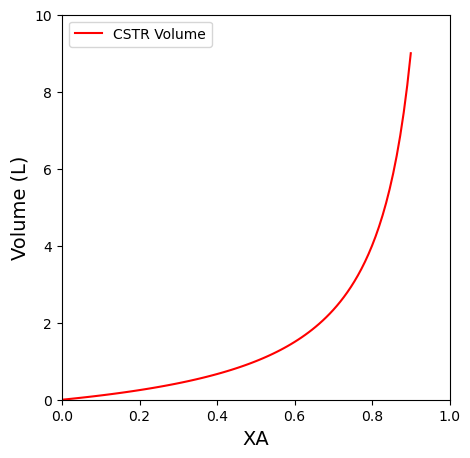

In [9]:
XA    = np.linspace(0.0, 0.9, 100)
order = 1
V     = VCSTR(XA, order)
plt.figure(1, figsize = (5,5))
plt.plot(XA, V, color = 'red', label = 'CSTR Volume')
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

#### Looping over multiple reaction orders

If I want to visualize this plot for multiple reaction orders, I *could* just re-paste versions of that code over and over, store the results, update the plots, etc., but this is very inefficient and clumsy. In situations like this where I want to just repeat a calculation for multiple values of a parameter, I just use a loop.  We can do this with a for loop.  

<b>Notice</b>: In the code cell below, we see that the for loop is iterating over the values of "alpha" in the array "avals."  This is a very Python way to iterate in a for loop (whereas the matlab approach would be to use an index as the counter).  Notice also that I've embedded a call to `plt.semilogy()` in the for loop so that I can update the label in the legend every time I consider a new reaction order.  Is that necessary? No, you can write out 5 different print statements, but I find it useful to be able to automate things like this, so it is worthwhile practicing the skill.

**Note**: I use a semilog plot here because the Volumes on the y-axis change by orders of magnitude, and I can't see those changes on a linear y axis.  Another thing to know: in python, we can continue stacking plots in the following way:

    plt.plot(X1, Y1, label = 'Y1')
    plt.plot(X2, Y2, label = 'Y2')
    plt.plot(X3, Y3, label = 'Y3')

I automate that below in the for loop.  Optional, of course.

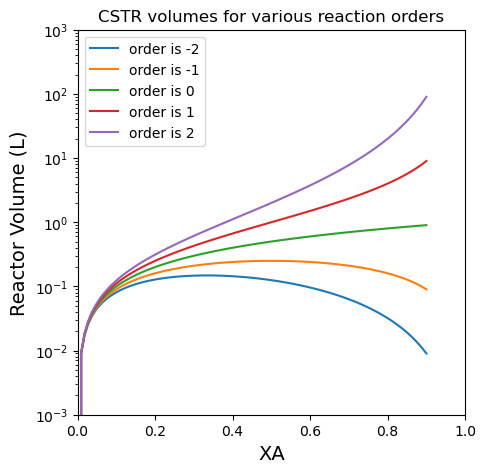

In [10]:
XA    = np.linspace(0, 0.9, 100)
avals = np.array([-2, -1, 0, 1, 2])

plt.figure(1, figsize = (5, 5))

for alpha in avals:
    V   = VCSTR(XA, alpha)
    plt.semilogy(XA, V, label = f'order is {alpha}')

plt.xlim(0,1)
plt.ylim(1e-3, 1e3)
plt.title('CSTR volumes for various reaction orders')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Reactor Volume (L)', fontsize = 14)
plt.legend()
plt.show()

## Solving the PFR problem for many conversions and many reaction orders

The PFR solution is actually a bit trickier.  Recall that the solution for the PFR volume for this simple case is:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

In other words, I have to solve the definite integral by integrating the right hand side from the lower limit of zero conversion to the upper limit of conversion I'm trying to achieve in this reactor to solve for the PFR Volume.  If I know the rate law exactly, I can solve this analytically (we did this in the Unit 03 Assignments).  In this case, we don't know the rate law per se, we want a general solution for any rate law.  The easiest way for me to do that is to substitute our generic rate law into the above definite integral:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{kC_{A,f}^\alpha \, (1 - X_A)^\alpha}$$

### Solving the PFR problem for a single conversion and single reaction order

Below, we'll solve this for a single exit conversion, and we notice: we still have to solve the integral from the lower limit (0) to the exit conversion.  I'm doing this with Gaussian quadrature.  I'll solve for 50% conversion since we know the answer should be 0.69L based on examples from class. Just to make sure we get the right answer before moving on.

In [11]:
alpha = 1
FAf = 1 #mol/min
Qf  = 1 #mol/min
CAf = 1 #mol/L
k   = 1 #1/min
XA  = 0.5
CA  = lambda X: CAf*(1 - X)
r   = lambda X: k*CA(X)**alpha

intfun   = lambda X: FAf/r(X)
vol, err = quadrature(intfun, 0, XA)
print(f'To achieve a conversion of {XA:0.2}, the PFR Volume must be {vol:3.3}L')

To achieve a conversion of 0.5, the PFR Volume must be 0.693L


### Embedding the solution of the definite integral inside of a function...

Again, I'd really like to make this general purpose and reusable, so i'm going to translate that calculation into a function that I can use to calculate PFR volume for *any* conversion and *any* reaction order.  This is the one I used in lecture.  We'll test it for 50% conversion and first order kinetics as usual to see if we get 0.69L.

In [12]:
def VPFR(XA, alpha):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    intfun   = lambda X: FAf/k/CAf**alpha/(1-X)**alpha
    vol, err = quadrature(intfun, 0, XA)
    return vol
XA = 0.5
order = 1
print(f'{VPFR(XA, order):3.3f}L')

0.693L


### We run into problems with broadcasting this function to many fractional conversions

In this case, we can't broadcast because we're using `quadrature()`, which takes a single floating point decimal or integer for the lower and upper limits of integration (see error below).  So, if we're want to calculate the PFR volume for multiple conversions using quadrature, we have to use a loop.

In [13]:
XA = np.linspace(0.0, 0.9, 100)
order = 1
print(VPFR(XA, order))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Running a for loop over an iterator created using the range function

Here's one way that we could write that loop -- we iterate over an index or "counter" and we use it to specify which element in the arrays we are working with. This is similar to the way you'd probably write a loop in Matlab.  In the cell below, I do this with the range function, which is probably similar to how we all learned to first write a for loop.

2.3025850836843293


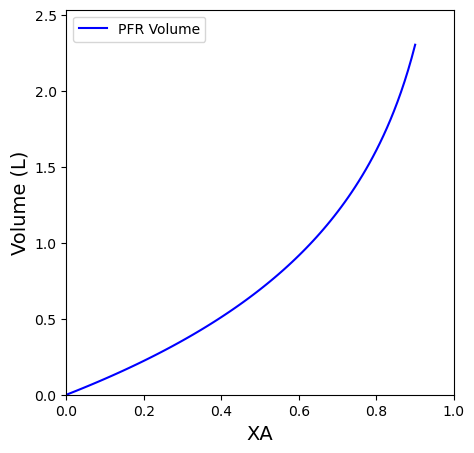

In [14]:
XA = np.linspace(0, 0.9, 100)
V  = np.zeros(len(XA))

for i in range(0, len(XA), 1):
    Vtemp,    err = quadrature(intfun, 0, XA[i])
    V[i], err = quadrature(intfun, 0, XA[i])
    V[i]      = VPFR(XA[i], order)

print(Vtemp)
    
plt.figure(1, figsize = (5,5))
plt.plot(XA, V, color = 'blue', label = 'PFR Volume')
plt.xlim(0, 1)
plt.ylim(0, max(V)*1.1)
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

### Running a for loop using the enumerate() function to create the iterator

Here's a slightly different (and more Pythonic) way to approach the problem -- it makes use of the `enumerate()` function, which returns both the value and the index of an element in an array.  Consider the code below and see if you can spot how it is different from the loop above that uses the range function.

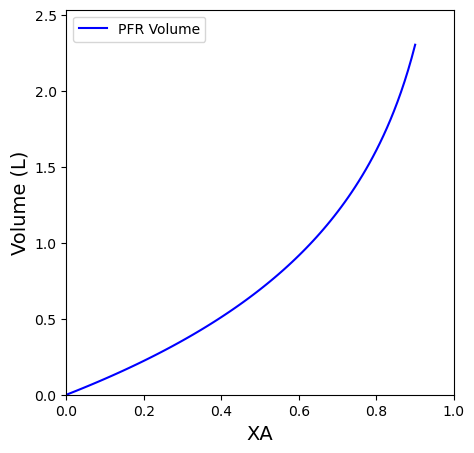

In [15]:
XA = np.linspace(0, 0.9, 100)
V  = np.zeros(len(XA))

for i, val in enumerate(XA):
    V[i], err = quadrature(intfun, 0, val)
    V[i]      = VPFR(XA[i], order)

plt.figure(1, figsize = (5,5))
plt.plot(XA, V, color = 'blue', label = 'PFR Volume')
plt.xlim(0, 1)
plt.ylim(0, max(V)*1.1)
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

### List comprehensions -- the most Python way of all

If you review the Notebook from L20, you'll see what is probably unfamiliar syntax (unless you have prior experience in Python). The way that I solved for PFR volumes in class was to use a list comprehension, which is basically a shorthand for loop.  It is a very Python bit of syntax.  I love them because they make it very fast and easy to write for loops.  To understand a list comprehension, you have to know a little about how we would use a for loop with lists to do the above operation (solve for the volume of a PFR for many different conversions using quadrature). 

If you reference our very first Recitation notebook (R01), you will recall that in base python, the `list` is the base array structure and that you can't really do math directly on a list. So let's say we wanted to calculate the square of all of the integers between 1 and 10 in base Python.  Our instinct at this point might be to try to broadcase the square operator `**2` to all of the values in our list...but we'll run into an error there.

In [ ]:
x = list(range(1,11))
print(x)
x**2

In base Python (that is, without working in numpy arrays), it would be mandatory to write a loop to do this.  So, a for loop is a natural choice here.  Working with lists:

In [ ]:
x = list(range(1,11))

squares = []

for value in x:
    squares.append(value**2) #this appends the current value of x^2 to the list "squares"

print(squares)
type(squares)

This type of scenario (needing to perform operations on each element of a list) is so common in base Python that there is a shorthand syntax that is equivalent to the above.  This is a list comprehension.  Basically, it performs an operation on each element of a list and stores the output of that operation in a new list.  It is the equivalent of the above for loop.

In [ ]:
x = list(range(1,11))
squares = [value**2 for value in x] 
print(squares)
type(squares)  #Notice: a comprehension will always return a list.

### Using a list comprehension to "broadcast" the VPFR function

In my solutions for L20, I used a comprehension to pass many conversions to the VPFR function.  This is roughly equivalent to the for loops written above using `range()` and `enumerate()`.

<div class = "alert alert-block alert-info">
    The list comprehension will generate a list...I converted it to a numpy array in the cell below so that it was the same type of array as XA.
    </div>

In [ ]:
XA = np.linspace(0, 0.9, 100)
order = 1

##This is the list comprehension; I'm solving the PFR volume for every XA in XA above
V = [VPFR(value, order) for value in XA]
print(type(V))

##Remember: a comprehension will always return a list of entries.  
##I am partial to numpy arrays, so I convert the list to a numpy array below
V = np.array(V)
print(type(V))

plt.figure(1, figsize = (5,5))
plt.plot(XA, V, color = 'blue', label = 'PFR Volume')
plt.xlim(0, 1)
plt.ylim(0, max(V)*1.1)
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

### Evaluating the PFR Volume for many fractional conversions and many reaction orders

If you wanted to calculate the PFR volume for many reaction orders, you'd need to nest loops somehow.  You can write two nested for loops, you can nest a comprehension in a for loop...you can probably even do a 2D comprehension, though I find comprehensions are best for *simple* for loops and it gets hard to keep dimensionality straight in one-liners.  Here's an example of one way to get the PFR volume for many conversions and several reaction orders. 

In [ ]:
XA    = np.linspace(0, 0.9, 100)
avals = [-2, -1, 0, 1, 2]

plt.figure(1, figsize = (5,5))

for alpha in avals:
    temp   = [VPFR(value, alpha) for value in XA]
    V      = np.array(temp)
    plt.semilogy(XA, V, label = f'order is {alpha}')

plt.xlim(0,1)
plt.ylim(1e-2, 1e2)
plt.title('PFR volumes for various reaction orders')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()

### Overlaying CSTR and PFR volumes in a single plot

At the risk of putting too much information into a single graph, it is worth considering how to control formatting for figures that are illustrating more complex data sets.  For example, below, I introduce list of strings that represent colors, and I can then use this to ensure that the CSTR and PFR volumes for a given reaction order are plotted in the same color.  If you study the code a bit, you'll see that it makes use of lists, numpy arrays, strings, floating point decimals, `enumerate()`, and list comprehensions.

In [ ]:
XA    = np.linspace(0, 0.9, 100)
avals = np.array([-2., -1., 0., 1., 2.])
colorset = ['black', 'blue', 'red', 'green', 'magenta']

plt.figure(1, figsize = (5, 5))

for i, alpha in enumerate(avals):
    VC     = VCSTR(XA, alpha)
    temp   = [VPFR(value, alpha) for value in XA]
    VP     = np.array(temp)
    plt.semilogy(XA, VC, linestyle = 'dashed', color = colorset[i])
    plt.semilogy(XA, VP, linestyle = 'solid', linewidth = 0.75, label = f'order is {alpha}', color = colorset[i])

plt.xlim(0,1)
plt.ylim(1e-2, 1e3)
plt.title('Comparison of CSTR and PFR volumes')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Reactor Volume (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show()